In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta
from math import comb
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Problem 1

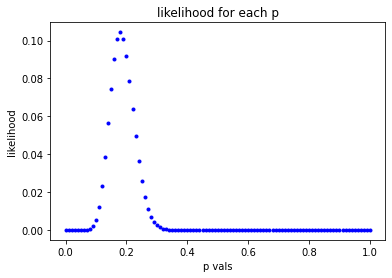

0.18

In [39]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    n_head = np.random.binomial(n,p) #get number of heads
    p_vals = np.linspace(0,1,101) #generate possible values for p
    pot_p = [(p**n_head)*((1-p)**(n-n_head)) for p in p_vals] #get probability of each p
    denom = np.sum(pot_p) #the integral
    pot_p = pot_p / denom #divide each p by the integral
    maxdex = np.argmax(pot_p) #get maximal element index
    MAP = p_vals[maxdex] #index it
    
    plt.plot(p_vals, pot_p,'b.')
    plt.title("likelihood for each p")
    plt.xlabel("p vals")
    plt.ylabel("likelihood")
    plt.show()
    
    return MAP

bernoulli_sampling(0.2,100)

# Problem 2

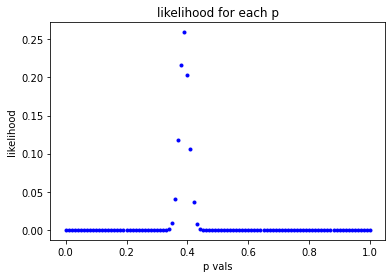

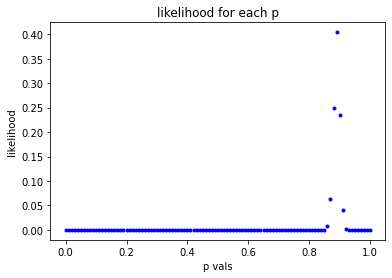

first coin has p of: 0.39
second coint has p of: 0.89


In [40]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    n_head = np.random.binomial(n,p) #get number of heads
    p_vals = np.linspace(0,1,101) #generate possible values for p
    prob_p = [(p**n_head)*((1-p)**(n-n_head))*prior.pdf(p) for p in p_vals] #generate diff probs for p
    denom = np.sum(prob_p) #integrate
    prob_p /= denom
    maxdex = np.argmax(prob_p) #get the maximizer
    MAP = p_vals[maxdex] #maximize
    
    plt.plot(p_vals, prob_p,'b.')
    plt.title("likelihood for each p")
    plt.xlabel("p vals")
    plt.ylabel("likelihood")
    plt.show()
    
    return MAP

map1 = non_uniform_prior(0.4,1000,beta(5,1.5))
map2 = non_uniform_prior(0.9,1000,beta(5,1.5))
print("first coin has p of:", map1)
print("second coint has p of:", map2)

# Problem 3

In [41]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. 
    """
    states = ["sun", "rain", "wind"]
    curr_st = "sun"
    ten_daze = []
    for i in range(10):
        curr_st_dex = np.random.choice(len(states),p=transition_matrix[states.index(curr_st)]) #update curr_state
        curr_st = states[curr_st_dex] #get label of the new state
        ten_daze.append(curr_st) #append label to list of ten states
        
    return ten_daze

In [43]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)
weather_forecast(transition_matrix, 10)

['sun', 'sun', 'sun', 'wind', 'sun', 'wind', 'wind', 'wind', 'rain', 'rain']

# Problem 4

In [48]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Print a trace plot. Return the mean for the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    model = pm.Model()
    with model:
        p = pm.Beta('p', alpha=1, beta=1) #initialize disribution of the p value
        y = pm.Bernoulli('y', p=p, observed=data) #generate outcomes
        trace = pm.sample(n) #sample n times
        
        az.plot_trace(trace) #plot different p values
        p = trace['p']
        mean = p.mean() #the mean p value
    
    return mean


<ipython-input-48-3ff03f45ca78>:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n) #sample n times
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8823837545458048, but should be close to 0.8. Try to increase the number of tuning steps.


0.15780538428773228

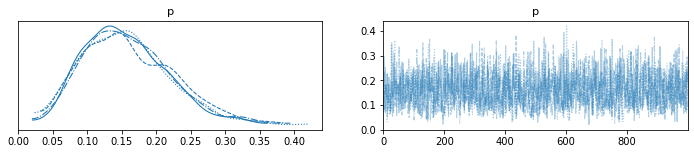

In [49]:
data = bernoulli.rvs(0.2, size=30)
posterior_sampling(data)

# Problem 5

In [50]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):

    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu,1/tau) where mu has a prior of Normal(m,s), and tau has
    a prior of Gamma(alpha,beta). Set up a PyMC3 model for this situation and sample 
    from the poterior n times. Print a trace plot for mu and tau. Return the mean 
    for the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    model = pm.Model()
    with model:
        tau = pm.Gamma('tau', alpha, beta) #initialize distribution of tau
        mu = pm.Normal('mu', m, s) #initialize distribution of mu
        ht = pm.Normal('heights', mu=mu, sd=1/tau, observed=observed_heights) #gen outcomes
        trace = pm.sample(n) #sample n times
        
        az.plot_trace(trace) #plot different mu values
        mu = trace['mu']
        plt.tight_layout()
        mean = mu.mean()
        
    
    return mean

<ipython-input-50-081d519303e6>:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n) #sample n times
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


178.6777863665258

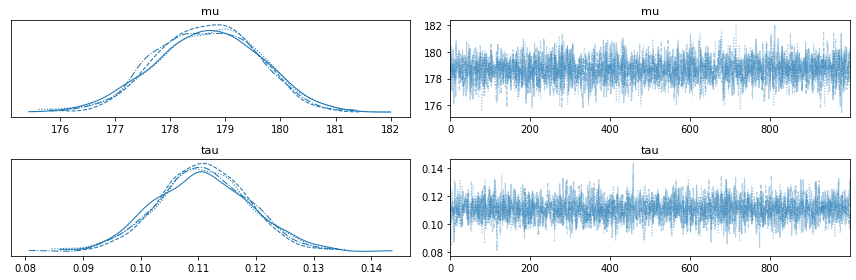

In [51]:
heights = np.random.normal(180,10,100)
height_model(heights)